# Demo
A demonstration notebook showing off how to use the `dmv.data.DataContainer` and the `dmv.layer.DynamicMultiViewRNN`.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

tf.keras.backend.set_floatx('float32')
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Settings

In [2]:
data_folder = r'C:\Users\jeroe\data\MURA\MURA-v1.1\small'
multi = False

## Data

In [3]:
from dmv.data import DataContainer

train_dc = DataContainer(data_folder, train=True, multi=multi, category='Shoulder')
valid_dc = DataContainer(data_folder, train=False, multi=multi, category='Shoulder')

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(128, 128, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0

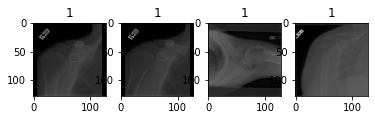

In [4]:
train_dc.show()

## Augmentation

## Model

In [5]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, TimeDistributed, Flatten
from tensorflow.keras import Model

from dmv.layer import DynamicMultiViewRNN

class DynamicMultiViewModel(Model):
    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.base = DenseNet169(include_top=False, input_shape=input_shape)
        
        self.agg = DynamicMultiViewRNN()
        self.dense = Dense(num_classes, activation='sigmoid')
    
    def call(self, x):
        x = TimeDistributed(self.base)(x)
        x = TimeDistributed(Flatten())(x)

        x = self.agg(x)
        x = self.dense(x)

        return x

In [6]:
class SingleViewModel(Model):
    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.base = DenseNet169(include_top=False, input_shape=input_shape)
        self.dense = Dense(100, activation='relu')
        self.classify = Dense(num_classes, activation='sigmoid')
    
    def call(self, x):
        x = self.base(x)
        x = Flatten()(x)
        x = self.dense(x)
        x = self.classify(x)
        
        return x

## Instantiating

In [7]:
from tensorflow.keras.losses import BinaryCrossentropy

if multi:
    model = DynamicMultiViewModel(1, train_dc._output_shape[-3:])
else:
    model = SingleViewModel(1, train_dc._output_shape[-3:])
    
model.build(tuple([train_dc._batch_size] + train_dc._output_shape))
model.compile(optimizer='adam',
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])
model.summary()

51879936/51877672 [==============================] - 3s 0us/step
Model: "single_view_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 4, 4, 1664)        12642880  
_________________________________________________________________
dense (Dense)                multiple                  2662500   
_________________________________________________________________
dense_1 (Dense)              multiple                  101       
Total params: 15,305,481
Trainable params: 15,147,081
Non-trainable params: 158,400
_________________________________________________________________


## Training

In [8]:
model.fit(
    x=train_dc.ds(),
    steps_per_epoch=train_dc.batches_per_epoch,
    validation_data=valid_dc.ds(),
    validation_steps=valid_dc.batches_per_epoch,
    epochs=5
)

Epoch 1/5
1048/1048 [==============================] - 93s 89ms/step - loss: 0.8440 - accuracy: 0.5076 - val_loss: 0.6931 - val_accuracy: 0.5062
Epoch 2/5
1048/1048 [==============================] - 88s 84ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5062
Epoch 3/5
1048/1048 [==============================] - 90s 86ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5062
Epoch 4/5
1048/1048 [==============================] - 88s 84ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6931 - val_accuracy: 0.5062
Epoch 5/5
1048/1048 [==============================] - 88s 84ms/step - loss: 0.6935 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5062
